In [64]:
%pylab notebook

# Run on CPU not GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import layers



import primo.models
import primo.datasets
import primo.tools.filepath as filepaths
import primo.tools.sequences as seqtools
import pandas as pd


Populating the interactive namespace from numpy and matplotlib


In [65]:
#encoder = primo.models.Encoder('/tf/primo/data/models/encoder-model-short.h5')
#encoder = primo.models.Encoder('/tf/primo/data/models/encoder-model-with-fit-prediction.h5')
#encoder = primo.models.Encoder('/tf/primo/data/models/encoder-model-with-fit-prediction-stronger-regularize.h5')
encoder = primo.models.Encoder('/tf/primo/data/models/encoder-function.h5')
#encoder = primo.models.Encoder()

# TODO: Replace the yield_predictor with the nucleaseq Cas9 predictor, use that here instead. https://github.com/uwmisl/cas9-similarity-search/issues/3 
#yield_predictor = primo.models.Predictor('/tf/primo/data/models/yield-model.h5')
#yield_predictor = primo.models.PredictorModel('/tf/primo/data/models/yield-model.h5')
yield_predictor = primo.models.PredictorFunction()
encoder.model.compile()
yield_predictor.model.compile()
encoder_trainer = primo.models.EncoderTrainer(encoder, yield_predictor)

# encoder_trainer.model.summary()

In [66]:
# Load queries and see what they encode to

query_features_filepath = filepaths.get_query_features_path(isDocker=True)
query_features = pd.read_hdf(query_features_filepath)
query_seqs = encoder.encode_feature_seqs(query_features)
print(f"Query Seqs: \n" + "\n".join(query_seqs))

def seq_str_to_input(seq):
    return np.transpose(seqtools.seqs_to_onehots(seq), [1, 0, 2])

# AACGAGCCAAAAATACGAGA
# TGGAGCCAGGCCATTGGACG
# TGGCACTAGACCCCTCGAGG

Query Seqs: 
TAGCAAAAGAGAGGGGCGCA
TATAAAAAGAGCGGGGCGCA
TAACAAAAGAGACGGGCGCA


In [67]:
def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

batch_size = 100
similarity_threshold = 75
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

batch_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

encoder_val_batches = keras_batch_generator(
    validation_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

batch = next(batch_generator)
del batch_generator

val_batch = next(encoder_val_batches)
del encoder_val_batches

switching to train_e.h5 and train_2.h5


In [68]:

seqs_softmax = encoder_trainer.calcseq.predict(batch[0])
print(seqs_softmax[0].shape)
primary_seqs = seqtools.onehots_to_seqs(seqs_softmax[:, 0, :, :])
secondary_seqs = seqtools.onehots_to_seqs(seqs_softmax[:, 1, :, :])
p_unique_count = len(np.unique(primary_seqs))
s_unique_count = len(np.unique(secondary_seqs))
print(f"Unique: {p_unique_count} / {len(primary_seqs)}")
print(f"Unique: {s_unique_count} / {len(secondary_seqs)}")

(2, 20, 4)
Unique: 42 / 100
Unique: 35 / 100


In [69]:
primary_seqs

array(['TATGAAAAGAGAGGGGCGCA', 'TCAAAAAAGAGAGGGGCGCA',
       'TCTGAAAAGAGCGGGGCGCA', 'TTTCAAAAGAGAGGGGCGCA',
       'TCACAAAAGAGAGGGGCGCA', 'TAAAAAAAGAGCGGGGCGCA',
       'TCACAAAAGAGACGGGCGCA', 'TATGAAAAGAGGGGGGCGCA',
       'TCTGAAAAGAGCCGGGCGCA', 'TAAGAAAAGAGACGGGCGCA',
       'TCCCAAAAGAGAGGGGCGCA', 'TCTCAAAAGAGAGGGGCGCA',
       'TCTAAAAAGAGCGGGGCGCA', 'TATAAAAAGAGAGGGGCGCA',
       'TATAAAAAGAGACGGGCGCA', 'TACAAAAAGAGAGGGGCGCA',
       'TATAAAAAGAGAGGGGCGCA', 'TATGAAAAGAGAGGGGCGCA',
       'TATCAAAAGAGAGGGGCGCA', 'TCTAAAAAGAGCGGGGCGCA',
       'TCAAAAAAGAGAGGGGCGCA', 'TCAAAAAAGAGCGGGGCGCA',
       'TCACAAAAGAGAGGGGCGCA', 'TATAAAAAGAGAGGGGCGCA',
       'TCACAAAAGAGGCGGGCGCA', 'TCACAAAAGAGACGGGCGCA',
       'TCTGAAAAGAGCGGGGCGCA', 'TAAAAAAAGAGAGGGGCGCA',
       'TTACAAAAGAGGGGGGCGCA', 'TCTCAAAAGAGAGGGGCGCA',
       'TCTCAAAAGAGAGGGGCGCA', 'TCTAAAAAGAGCGGGGCGCA',
       'TAAAAAAAGAGTGGGGCGCA', 'TCAAAAAAGAGAGGGGCGCA',
       'TAAAAAAAGAGAGGGGCGCA', 'TACAAAAAGAGAGGGGCGCA',
       'TA

<IPython.core.display.Javascript object>


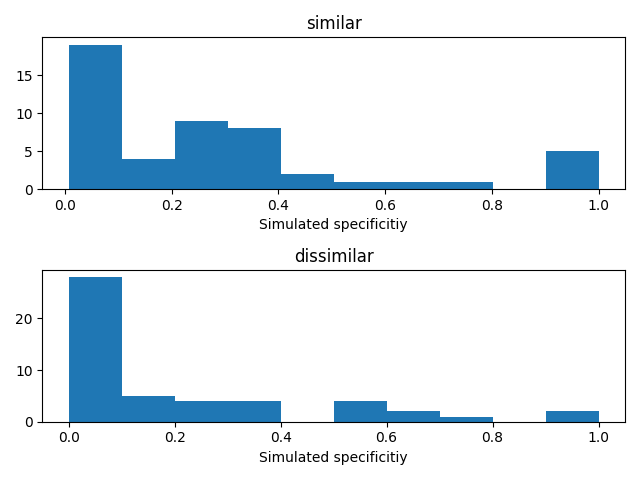

[0.02905826 0.0192168  0.38100654 0.15015414 0.02864362 0.28585351
 0.1660853  0.01119982 0.31222703 0.43338301 1.         0.01119982
 0.35077807 1.         0.28585351 0.26152898 0.38100654 0.00845403
 0.2389826  0.14904979 0.04117117 0.00999225 0.26152898 0.01004756
 0.48607932 0.24103912 0.16967699 0.68641599 0.0094529  0.02864362
 0.01523662 0.04394227 1.         1.         0.01966144 0.39100573
 0.35077807 0.77494931 0.03907085 0.2389826  1.         0.01450172
 0.27080051 0.04394227 0.52991282 0.3838716  0.00713995 0.39100573
 0.23672344 0.02710689]


In [70]:
simulator = primo.models.Simulator()
scores = simulator.simulate(pd.DataFrame({
    'query_features': primary_seqs,
    'target_features': secondary_seqs,
}))
plt.figure()
true_idx = batch[1] > 0.5;
false_idx = batch[1] <= 0.5;
plt.subplot(2,1,1);
print(scores[true_idx])
plt.hist(scores[true_idx]);
plt.title('similar')
plt.xlabel('Simulated specificitiy')
plt.subplot(2,1,2);
plt.hist(scores[false_idx]);
plt.title('dissimilar')
plt.xlabel('Simulated specificitiy')
plt.tight_layout()

<IPython.core.display.Javascript object>


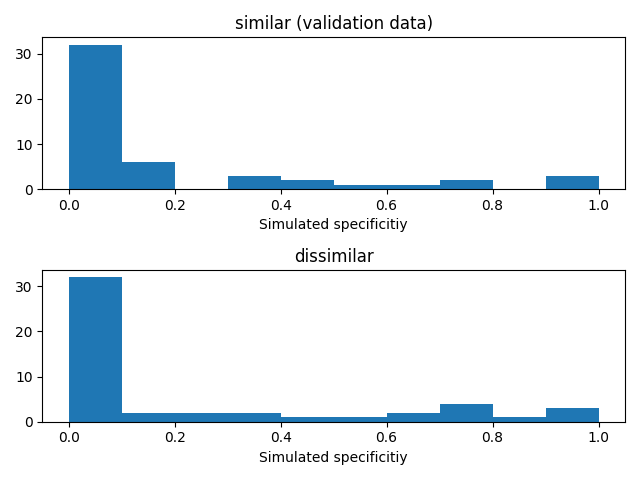

In [71]:
seqs_softmax = encoder_trainer.calcseq.predict(val_batch[0])
primary_seqs = seqtools.onehots_to_seqs(seqs_softmax[:, 0, :, :])
secondary_seqs = seqtools.onehots_to_seqs(seqs_softmax[:, 1, :, :])
simulator = primo.models.Simulator()
scores = simulator.simulate(pd.DataFrame({
    'query_features': primary_seqs,
    'target_features': secondary_seqs,
}))
plt.figure()
true_idx = batch[1] > 0.5;
false_idx = batch[1] <= 0.5;
plt.subplot(2,1,1);
plt.hist(scores[true_idx]);watch -n 1 nvidia-smiwatch -n 1 nvidia-smi
plt.title('similar (validation data)')
plt.xlabel('Simulated specificitiy')
plt.subplot(2,1,2);
plt.hist(scores[false_idx]);
plt.title('dissimilar')
plt.xlabel('Simulated specificitiy')
plt.tight_layout()


In [50]:
same_pair = np.array([[query_features.loc['luis_lego'], query_features.loc['luis_lego']]])
a = encoder_trainer.model.predict(same_pair)
print(f"Full model: {a}")

b = encoder_trainer.predictor.model.predict(np.array([
    np.concatenate([
        seq_str_to_input('GCTTAGAACGCGCAAAGCGC'),
        seq_str_to_input('GCTTAGAACGCGCAAAGCGC'),
    ]),
]))
print(f"Predictor with sequences: {b}")

c = encoder_trainer.calcseq.predict(same_pair)
print(f"Encoded onehot seqs: {c}")
print(c.shape)
print(f"as strings: {seqtools.onehots_to_seqs(c[0])}")
d = encoder_trainer.predictor.model.predict(c)
print(f"predictor on onehot: {d}")

Full model: [0.7181878]
Predictor with sequences: [1.]
Encoded onehot seqs: [[[[2.09453137e-05 2.09453137e-05 2.09453137e-05 9.99937177e-01]
   [9.40733254e-01 1.52985915e-03 5.62070124e-02 1.52985915e-03]
   [1.45350699e-03 1.45350699e-03 9.11611378e-01 8.54816213e-02]
   [9.99994278e-01 1.86861087e-06 1.86861087e-06 1.86861087e-06]
   [4.96530652e-01 5.03441155e-01 1.06859934e-05 1.75342157e-05]
   [1.07171200e-02 2.89512653e-04 2.89512653e-04 9.88703787e-01]
   [1.68692154e-07 1.04852674e-07 9.99999642e-01 1.04852674e-07]
   [7.50097632e-02 5.34884810e-01 7.50097632e-02 3.15095574e-01]
   [3.97345389e-07 2.44427997e-06 9.99996781e-01 3.97345389e-07]
   [7.10423410e-01 9.66352895e-02 7.35342354e-02 1.19407006e-01]
   [5.08738276e-06 9.99994636e-01 1.38162846e-07 1.38162846e-07]
   [3.32486071e-02 3.32486071e-02 4.70910996e-01 4.62591738e-01]
   [1.75624373e-05 1.75624373e-05 1.22371435e-04 9.99842525e-01]
   [6.08496547e-01 1.02606218e-03 3.76888782e-01 1.35885943e-02]
   [8.64522606